(uqnl)= 
# Reliable Classification

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings("ignore")

<div align="justify">

To the best of our knowledge, {cite:t}`mpub272` were the first to explicitly motivate the distinction between aleatoric and epistemic uncertainty in a machine learning context. Their approach leverages the concept of *normalized likelihood*. Moreover, it combines set-based and distributional (probabilistic) inference, and thus can be positioned in-between version space learning and Bayesian inference as discussed in Section {ref}`sbvd`. Since the approach contains concepts that might be less known to a machine learning audience, our description is a bit more detailed than for the other methods discussed in this section. 


Consider the simplest case of binary classification with classes $\set{Y} := \{-1, +1\}$, which suffices to explain the basic idea (and which has been generalized to the multi-class case by {cite:t}`mpub385`). {cite:t}`mpub272` focus on predictive uncertainty and derive degrees of uncertainty in a prediction in two steps, which we are going to discuss in turn:

- First, given a query instance $\vec{x}_q$, a degree of "plausibility" is derived for each candidate outcome $y \in \set{Y}$. These are degrees in the unit interval, but no probabilities. As they are not constrained by a total mass of 1, they are more apt at capturing a lack of knowledge, and hence epistemic uncertainty (cf. Section {ref}`rlk`).
- Second, degrees of aleatoric and epistemic uncertainty are derived from the degrees of plausibility.

</div>


## Modelling the plausibility of predictions

<div align="justify"> 

Recall that, in version space learning, the plausibility of both hypotheses and outcomes are expressed in a purely bivalent way: according to {eq}`ee1`, a hypotheses is either considered possible/plausible or not ($\llbracket h \in \mathcal{V} \rrbracket$), and an outcome $y$ is either supported or not ($\llbracket h(\vec{x}) = y \rrbracket$). {cite:t}`mpub272` generalize both parts of the prediction from bivalent to *graded* plausibility and support: A hypothesis $h \in \cH$ has a degree of plausibility $\pi_{\cH}(h) \in [0,1]$, and the support of outcomes $y$ is expressed in terms of probabilities $h(\vec{x}) = \prob(y \given \vec{x}) \in [0,1]$.  

</div>

### Normalized likelihood

<div align="justify"> 

More specifically, referring to the notion of *normalized likelihood*, 
a plausibility distribution on $\cH$ (i.e., a plausibility for each hypothesis $h \in \cH$) is defined as follows:
$$
\pi_{\cH}(h) := \frac{L(h)}{\sup_{h' \in \cH} L(h')}  = \frac{L(h)}{L(h^{ml})} \enspace ,
$$(noli)
where $L(h)$ is the likelihood of the hypothesis $h$ on the data $\set{D}$ (i.e., the probability of $\set{D}$ under this hypothesis), and $h^{ml} \in \cH$ is the maximum likelihood (ML) estimation. Thus, the plausibility of a hypothesis is in proportion to its likelihood[^footNoteIdentifier], with the ML estimate having the highest plausibility of 1.

</div>

<div align="justify"> 

For illustration we use a simple biased coin flipping example. With probability $\theta$ head is drawn ($1$) and with probability ($1 - \theta$) tails ($0$). We denote by $n$ the number of heads in the data and by $m$ the number of tails. To avoid numerical problems we use the log likelihood which is then given by:
\begin{equation}
	\log L(\theta) = \sum_{i=1}^{N}\log(P(X_{i}|\theta)) = n \log(\theta) + m \log(1-\theta).
\end{equation}

The likelihood maximizer is then simply given by the share of heads in the data: $\hat{\theta}=\frac{n}{n + m}$.

</div>

<div align="justify"> 

We illustrate this by plotting the log likelihood as a function of the hypotheses for the different values of $\theta$.

</div>

In [3]:
# computes the likelihood for a given theta
def log_likelihood(data, theta):
	n = np.sum(data == 1)
	m = len(data) - n
	ll = n*np.log(theta +1e-9) + m *np.log(1-theta+1e-9)

	return ll

# computes the normalized log likelihood L(h) / L(h_ml)
def norm_log_likelihood(data, theta):

	ll = log_likelihood(data, theta)
	ll_ml = log_likelihood(data, np.mean(data))

	norm_ll = np.exp(ll - ll_ml)

	return norm_ll

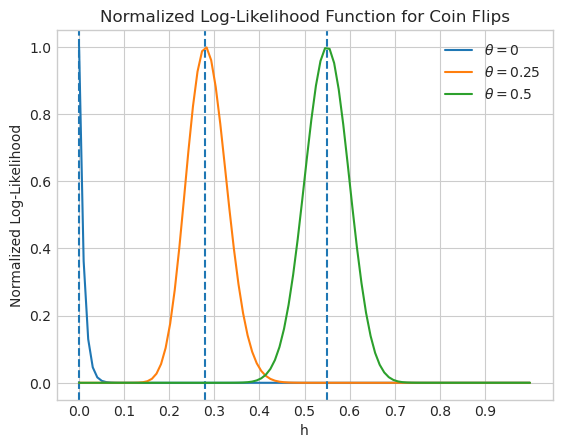

In [4]:
h_theta = np.linspace(0.0, 1.0, 100)
N = 100

fig, ax = plt.subplots()

for theta in [0, 0.25, 0.5]:

	result = np.zeros_like(h_theta)

	data = np.random.binomial(1, theta, N)
	norm_likelihood = norm_log_likelihood(data, h_theta)
	result += norm_likelihood

	ax.plot(h_theta, result, label=f'$\\theta = {theta}$')

	ax.axvline(x = np.mean(data), linestyle='--')

plt.xticks(np.arange(10) / 10)
plt.ylabel('Normalized Log-Likelihood')
plt.xlabel('h')
plt.title('Normalized Log-Likelihood Function for Coin Flips')
plt.legend()
plt.show()

<div align="justify"> 

We can see that the normalized likelihood is the highest for the maximum likelihood estimate (blue line) and decreases symmetrically when diverging from it.

</div>

<div align="justify"> 

The second step, both in version space and Bayesian learning, consists of translating uncertainty on $\cH$ into uncertainty about the prediction for a query $\vec{x}_q$. To this end, all predictions $h(\vec{x}_{q})$ need to be aggregated, taking into account the plausibility of the hypotheses $h \in \cH$. Due to the problems of the averaging approach ({eq}`pd`) in Bayesian inference, a generalization of the existential aggregation {eq}`ee1` used in version space learning is adopted:  

$$
\pi(+1 \given \vec{x}_{q}) := \sup_{h \in \cH} \min\big( 
\pi_{\cH}(h) , \pi(+1 \given h, \vec{x}_{q}) \big) ,
$$(plaus)

where $\pi(+1 \given h, \vec{x}_{q})$ is the \emph{degree of support} of the positive class provided by $h$\footnote{Indeed, $\pi(\cdot \given h, \vec{x}_{q})$ should not be interpreted as a measure of uncertainty.}. This measure of support, which generalizes the all-or-nothing support $\llbracket h(\vec{x}) = y \rrbracket$ in {eq}`ee1`, is defined as follows: 

$$
\pi(+1 \given h, \vec{x}_{q}) := \max \big(2 h(\vec{x}_{q})-1, 0 \big).
$$(supp)

Thus, the support is 0 as long as the probability predicted by $h$ is $\leq 1/2$, and linearly increases afterward, reaching 1 for $h(\vec{x}_{q})=1$. Recalling that $h$ is a probabilistic classifier, this clearly makes sense, since values $h(\vec{x}_{q}) \leq 1/2$ are actually more in favor of the negative class, and therefore no evidence for the positive class. Also, as will be seen further below, this definition assures a maximal degree of aleatoric uncertainty in the case of full certainty about the uniform distribution $h_{1/2}$, wich is a desirable property. 
Since the supremum operator in {eq}`plaus` can be seen as a generalized existential quantifier, the expression {eq}`plaus` can be read as follows: The class $+1$ is plausible insofar there exists a hypothesis $h$ that is plausible and that strongly supports $+1$. Analogously, the plausibility for $-1$ is defined as follows:

$$
\pi(-1 \given \vec{x}_{q}) := \sup_{h \in \cH} \min\big( 
\pi_{\cH}(h) , \pi(-1 | h, \vec{x}_{q}) \big) ,
$$(plausminus)

with $\pi(-1 \given h, \vec{x}_{q}) = \max(1 - 2 h(\vec{x}_{q}), 0)$.

</div>

<div align="justify"> 

We can illustrate the concept of plausability by plotting $\pi(+1 \given h, \vec{x}_{q})$ and $\pi(-1 \given h, \vec{x}_{q})$ as functions of the number of observations for different values of $\theta$. To have a smooth estimate we average over $100$ repetitions:

</div>

In [163]:
def get_plausability(data):

	if len(data) == 0:
		return 1
	h_theta = np.linspace(0.0, 1.0, 100)
	norm_likelihood = norm_log_likelihood(data, h_theta)

	support_pos = np.max(np.vstack([2*h_theta -1, np.zeros_like(h_theta)]), axis=0)
	support_neg = np.max(np.vstack([1 - 2*(h_theta), np.zeros_like(h_theta)]), axis=0)

	pl_pos = np.max(np.min(np.vstack([norm_likelihood, support_pos]), axis=0))
	pl_neg = np.max(np.min(np.vstack([norm_likelihood, support_neg]), axis=0))

	return pl_pos, pl_neg

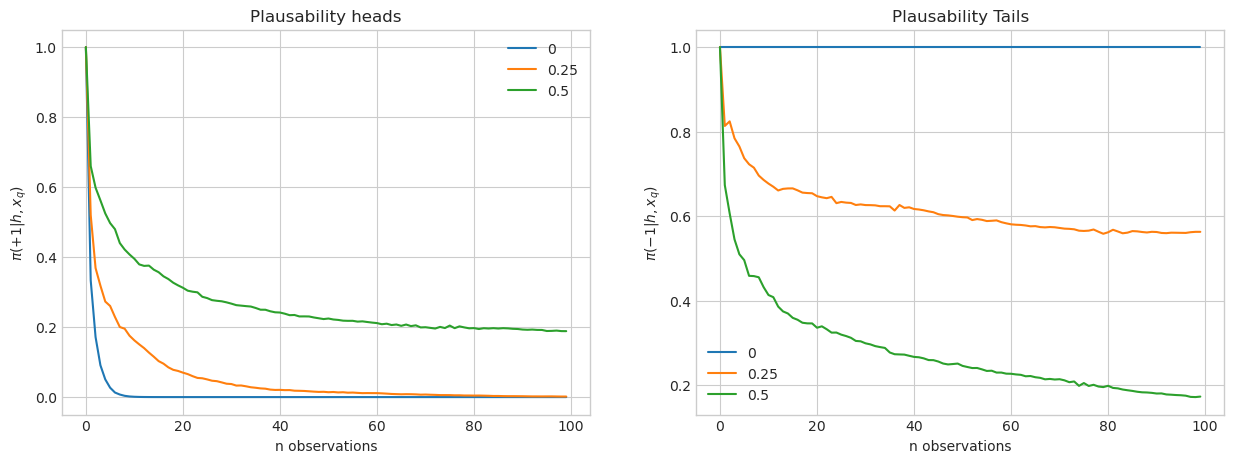

In [126]:
h_theta = np.linspace(0.0, 1.0, 100)
n_repetitions = 100
N = 100

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for theta in [0, 0.25, 0.5]:

	result = np.zeros((n_repetitions, 2, N))

	for i in range(n_repetitions):
		data = np.random.binomial(1, theta, N)
		

		for j in range(N):
			result[i, :, j] = get_plausability(data[:j])

	result = np.mean(result, axis=0)
	
	axes[0].plot(result[0, :], label=theta)
	axes[1].plot(result[1, :], label=theta)
axes[0].legend()
axes[1].legend()
	
axes[0].set_title('Plausability heads')
axes[1].set_title('Plausability Tails')

axes[0].set_xlabel('n observations')
axes[1].set_xlabel('n observations')
axes[0].set_xlabel('n observations')
axes[0].set_ylabel('$\pi(+1 | h, x_{q})$')
axes[1].set_ylabel('$\pi(-1 | h, x_{q})$')

plt.show()

<div align="justify"> 

We can see that at the beginning everything is completely plausible as we did not make any observations yet. As the number of observations grows the plausability decreases and converges against some value. 

</div>

## From plausability to epistemic uncertainty

<div align="justify"> 

Given the plausibilities $\pi(+1) = \pi(+1 | \vec{x}_{q})$ and $\pi(-1) = \pi(-1 | \vec{x}_{q})$ of the positive and negative class, respectively, and having to make a prediction, one would naturally decide in favor of the more plausible class. Perhaps more interestingly, meaningful definitions of epistemic uncertainty $u_e$ and aleatoric uncertainty $u_a$ can be defined on the basis of the two degrees of plausibility: 

$$
u_e & := \min \big( \pi(+1 ) , \pi(-1) \big) \\
u_a &  :=  1 - \max \big( \pi(+1) , \pi(-1) \big)
$$(ep)

Thus, $u_e$ is the degree to which both $+1$ and $-1$ are plausible\footnote{The minimum plays the role of a generalized logical conjunction {cite:t}`klem_tn`.}, and $u_a$ the degree to which neither $+1$ nor $-1$ are plausible.
Since these two degrees of uncertainty satisfy $u_a + u_e  \leq 1$,
the total uncertainty (aleatoric $+$ epistemic) is upper-bounded by 1. Strictly speaking, since the degrees $\pi(y)$ should be interpreted as upper bounds on plausibility, which decrease in the course of time (with increasing sample size), the uncertainty degrees {eq}`ep` should be interpreted as bounds as well. For example, in the very beginning, when no or very little data has been observed, both outcomes are fully plausible ($\pi(+1) = \pi(-1) = 1$), hence $u_e = 1$ and $u_a = 0$. This does not mean, of course, that there is no aleatoric uncertainty involved. Instead, it is simply not yet known or, say, confirmed. Thus, $u_a$ should be seen as a lower bound on the ``true'' aleatoric uncertainty. For instance, when $y$ is the outcome of a fair coin toss, the aleatoric uncertainty will increase over time and reach 1 in the limit, while $u_e$ will decrease and vanish at some point: Eventually, the learner will be fully aware of facing full aleatoric uncertainty.    


We can demonstrate this by plotting the epistemic and aleatoric uncertainty for different values of $\theta$ as a function of the number of observations:

</div>

In [139]:
def get_uncertainty(data):
	plausabilities = get_plausability(data[:j])

	ue = np.round(np.min(plausabilities, axis=0),3)
	ua = np.round(1 - np.max(plausabilities, axis=0),3)

	return ue, ua

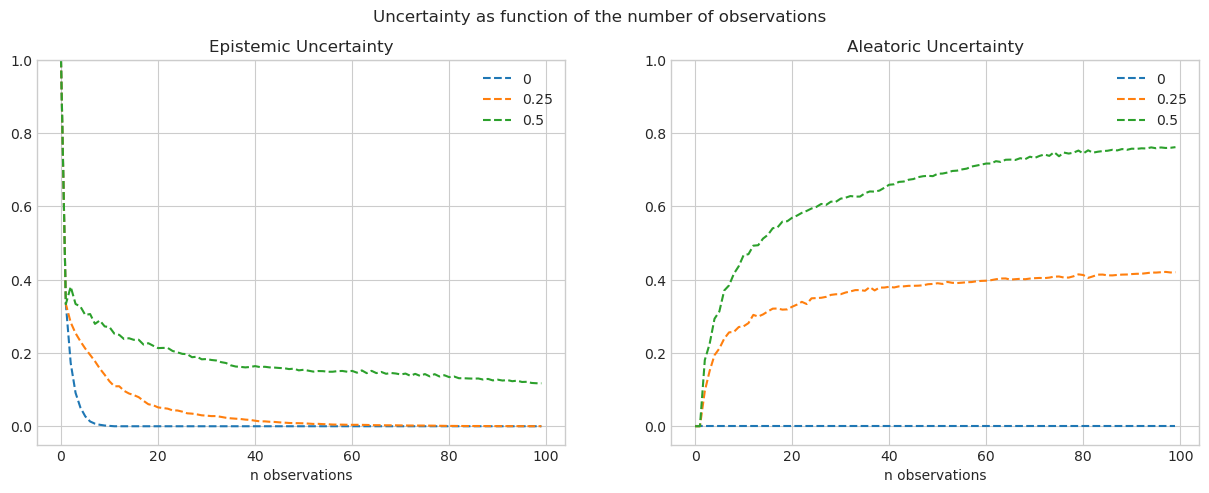

In [140]:
h_theta = np.linspace(0.0, 1.0, 100)
n_repetitions = 100
N = 100


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

for theta in [0, 0.25, 0.5]:

	result = np.zeros((n_repetitions, 2, N))

	for i in range(n_repetitions):
		data = np.random.binomial(1, theta, N)
		
		for j in range(N):
			result[i, :, j] = get_uncertainty(data[:j])

	result = np.mean(result, axis=0)
	
	axes[0].plot(result[0, :], label=theta, linestyle='--')
	axes[1].plot(result[1, :], label=theta, linestyle='--')
axes[0].legend()
axes[1].legend()
	
axes[0].set_title('Epistemic Uncertainty')
axes[1].set_title('Aleatoric Uncertainty')
axes[0].set_ylim(-0.05,1)
axes[1].set_ylim(-0.05,1)

axes[0].set_xlabel('n observations')
axes[1].set_xlabel('n observations')
plt.suptitle('Uncertainty as function of the number of observations')
plt.show()

<div align="justify"> 

We can see that the epistemic uncertainty is very high at the beginning as we have no knowledge about the true $\theta$. As we see make more and more observations we gain more knowledge about $\theta$ and the epistemic uncertainty increases. In the limit it will vanish comletely, because we can estimate $\theta$ perfectly. The aleatoric uncertainty on the other hand increases with growing number of observations as the learner becomes more and more aware of the stochasticity of the process.

</div>

<div align="justify"> 

More generally, the following special cases might be of interest:

- *Full epistemic uncertainty*: $u_e = 1$ requires the existence of at least two fully plausible hypotheses (i.e., both with the highest likelihood), the one fully supporting the positive and the other fully supporting the negative class. This situation is likely to occur (at least approximately) in the case of a small sample size, for which the likelihood is not very peaked. 


- *No epistemic uncertainty*: $u_e = 0$ requires either $\pi(+1) = 0$ or $\pi(-1)=0$, which in turn means that $h(\vec{x}_{q}) < 1/2$ for all hypotheses with non-zero plausibility, or $h(\vec{x}_{q}) > 1/2$ for all these hypotheses. In other words, there is no disagreement about which of the two classes should be favored. Specifically, suppose that all plausible hypotheses agree on the same conditional probability distribution $\prob(+1 \given \vec{x}) = \alpha$ and $\prob(-1 \given \vec{x}) = 1-\alpha$, and let $\beta = \max(\alpha , 1- \alpha)$. In this case, $u_e = 0$, and the degree of aleatoric uncertainty $u_a = 2(1- \beta)$ depends on how close $\beta$ is to 1. 

- *Full aleatoric uncertainty*: This is a special case of the previous one, in which $\beta = 1/2$. Indeed, $u_a = 1$ means that all plausible hypotheses assign a probability of $1/2$ to both classes. In other words, there is an agreement that the query instance is a boundary case.

- *No uncertainty*: Again, this is a special case of the second one, with $\beta = 1$. A clear preference (close to 1) in favor of one of the two classes means that all plausible hypotheses, i.e., all hypotheses with a high likelihood, provide full support to that class.

Although algorithmic aspects are not in the focus of this paper, it is worth to mention that the computation of {eq}`plaus`, and likewise of {eq}`plausminus`, may become rather complex. In fact, the computation of the supremum comes down to solving an optimization problem, the complexity of which strongly depends on the hypothesis space $\cH$. 

</div>

[^footNoteIdentifier]: In principle, the same idea can of course also be applied in Bayesian inference, namely by defining plausibility in terms of a normalized posterior distribution.